In [118]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_2'
model_variant = 'base'

training_size = 75000
test_size = 25000

In [119]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import models
import os
import time
import tensorflow as tf
from keras import callbacks
pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [120]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
75000 samples are taken from the head for training
25000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
74995,9735,meant,mean,VERB,-0.079156,M
74996,9735,disrespect,disrespect,NOUN,0.000000,M
74997,9737,Skiing,skiing,NOUN,0.000000,M
74998,9737,individual,individual,ADJ,-0.117658,M


In [121]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

def gender_seq_to_single(seqs):
    genders = []
    for seq in seqs:
        genders.append(seq[0])
    return genders

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_9848/2965456592.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_9848/2965456592.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
8222,9731,"[return, discipl...","[return, discipl...","[VERB, ADJ, NOUN...",[-0.174658146948...,M
8223,9733,"[remarks, race, ...","[remark, race, s...","[NOUN, NOUN, NOU...","[0.0, -0.0718725...",M
8224,9734,"[team, event, sc...","[team, event, sc...","[NOUN, NOUN, VERB]",[-0.582462135797...,M
8225,9735,"[issued, apology...","[issue, apology,...","[VERB, NOUN, PRO...",[-0.136028259061...,M


In [122]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,4599,"[Michigan, State...","[Michigan, State...","[PROPN, PROPN, P...","[0.0, -0.0984635...",F
1,910,"[Rising, rents, ...","[rise, rent, pus...","[VERB, NOUN, VER...",[-0.111356733596...,M
2,6580,"[company, disclo...","[company, disclo...","[NOUN, VERB, VER...",[-0.885393589966...,M
3,9167,"[tweeters, sugge...","[tweeter, sugges...","[NOUN, VERB, ADJ...","[0.0, -0.0423586...",M
4,77,"[apologize, felt...","[apologize, feel...","[NOUN, VERB, ADJ...",[0.0093559535253...,F
...,...,...,...,...,...,...
8222,6982,"[Cigna, offer, c...","[Cigna, offer, c...","[PROPN, VERB, VE...","[0.0, -0.1917789...",M
8223,3516,"[Authorities, qu...","[authority, quic...","[NOUN, ADV, VERB...",[-0.025347077124...,F
8224,5280,"[important, tell...","[important, tell...","[ADJ, VERB, NOUN...",[-0.149686474839...,F
8225,1869,"[ve, got, covere...","[ve, get, cover,...","[AUX, VERB, VERB...","[0.0, -0.1132411...",F


<AxesSubplot:>

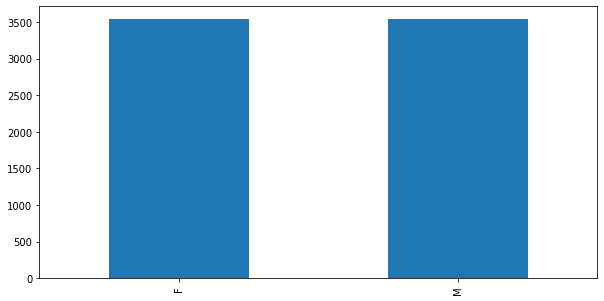

In [123]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
def equal_genders(data_):
    M, F = data_["Gender"].value_counts()
    if M>F:
        diff = M-F
        return data_.drop(data_.loc[data_['Gender'] == 'M'].index[:diff], axis=0)
    elif F>M:
        diff = F-M
        return data_.drop(data_.loc[data_['Gender'] == 'F'].index[:diff], axis=0)

train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [124]:
# DEFINE FUNCTION FOR PLOTTING SENTENCE LENGTHS
def plot_sentence_lengths(data_):
    sentence_plot = data_["Word"].values
    sentence_plot_sorted = list(sorted(sentence_plot, key=len))
    c = Counter(map(len, sentence_plot_sorted))

    total_sentences = 0
    total_words = 0
    for i in c:
        total_sentences = total_sentences + c[i]
        total_words = total_words + c[i]*i

    sentences_80_pct = total_sentences / 100 * 90
    words_80_pct = total_words / 100 * 90

    boundary_sen = 0
    counter_sen = 0

    for i in c:
        if(counter_sen + c[i] < int(sentences_80_pct)):
            counter_sen = counter_sen + c[i]
            boundary_sen = i
        else:
            break

    boundary_word = 0
    counter_word = 0

    for i in c:
        if(counter_word + c[i] * i < int(words_80_pct)):
            counter_word = counter_word + c[i] * i
            boundary_word = i
        else:
            break


    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


    plt.figure(figsize=[10,6])
    bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

    # for r in bars.get_children():
    #     if(r.get_x() > boundary_sen):
    #         r.set_alpha(0.2)

    plt.legend(loc="best")
    plt.ylim([0, max(list(c.values()))+10])
    ax2 = plt.gca()

    ymin, ymax = ax2.get_ylim()
    plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
    # plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

    plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
    plt.legend()
    plt.show()
    return boundary_sen

No handles with labels found to put in legend.


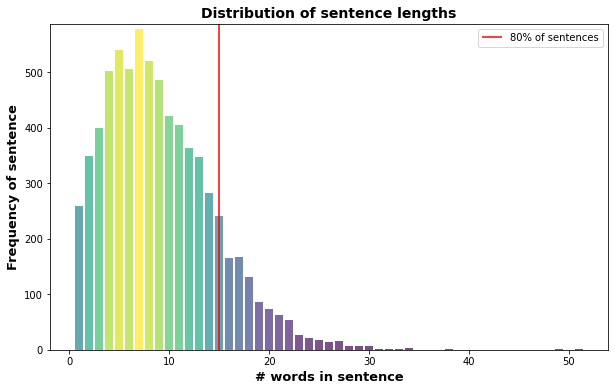

Decision boundary / 80 pct of sentence lengths is: 15


In [125]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [126]:
# ONE-HOT TARGET (GENDER)
classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_unique_classes = len(classes)

pol_to_enc = {
    -1.0: 1,
    -0.9: 2,
    -0.8: 3,
    -0.7: 4,
    -0.6: 5,
    -0.5: 6,
    -0.4: 7,
    -0.3: 8,
    -0.2: 9,
    -0.1: 10,
    0.0: 11,
    0.1: 12,
    0.2: 13,
    0.3: 14,
    0.4: 15,
    0.5: 16,
    0.6: 17,
    0.7: 18,
    0.8: 19,
    0.9: 20,
    1.0: 21
}

def round_list(list):
    rounded_pols = []
    for seq in list:
        rounded_pols.append([round(pol,1) for pol in seq])
    return rounded_pols

def encode_list(list):
    # le = LabelEncoder()
    # le.fit_transform(classes)

    # encoded_pols = []
    # for seq in list:
    #     encoded_pols.append(le.transform(seq))
    # return encoded_pols

    encoded_pols = []
    for seq in list:
        encoded_pols.append([pol_to_enc[pol] for pol in seq])
    return encoded_pols

def one_hot_list(list):
    one_hot_pols = []
    for seq in list:
        one_hot_pols.append([to_categorical(pol, n_unique_classes) for pol in seq])
    return one_hot_pols

train_pols_rounded = round_list(train_data['Polarity'])
train_pols_encoded = encode_list(train_pols_rounded)
y_train = one_hot_list(train_pols_encoded)

test_pols_rounded = round_list(test_data['Polarity'])
test_pols_encoded = encode_list(test_pols_rounded)
y_test = one_hot_list(test_pols_encoded)


print("Unique polarities:", [classes])
print("Unique polarities:", encode_list([classes]))

print("\nTraining data example polarity sequence:", train_data['Polarity'][:1].tolist())
print("Training data example polarity sequence rounded:", train_pols_rounded[0])
print("Training data example polarity sequence encoded:", train_pols_encoded[0])
print("Training data example polarity sequence one-hot:", y_train[0])

print("\nTest data example polarity sequence:", test_data['Polarity'][:1].tolist())
print("Test data example polarity sequence rounded:", test_pols_rounded[0])
print("Test data example polarity sequence encoded:", test_pols_encoded[0])
print("Test data example polarity sequence one-hot:", y_test[0])

Unique polarities: [[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]
Unique polarities: [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]]

Training data example polarity sequence: [[0.0, -0.09846358222124, -0.103276384861509, -0.39980527030886204, -0.14574837817813502, 0.0, -0.8853935899661751, 0.0, -0.06663620671221901, -0.15813499174391601, -0.12896740562935102, -0.061355233228529, 0.008306686495764, -0.068328972963, 0.161111829635837, 0.017890809564221, -0.145966862971732, 0.0, -0.09846358222124, -0.022038518948314, -0.265826402541593]]
Training data example polarity sequence rounded: [0.0, -0.1, -0.1, -0.4, -0.1, 0.0, -0.9, 0.0, -0.1, -0.2, -0.1, -0.1, 0.0, -0.1, 0.2, 0.0, -0.1, 0.0, -0.1, -0.0, -0.3]
Training data example polarity sequence encoded: [11, 10, 10, 7, 10, 11, 2, 11, 10, 9, 10, 10, 11, 10, 13, 11, 10, 11, 10, 11, 8]
Training data example polarity sequence one-hot: [array([0.

In [127]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
def encode_feature(train_data_, test_data_):
    tokenizer = Tokenizer()
    # ONLY FIT ON TRAIN DATA
    tokenizer.fit_on_texts(train_data_)
    return tokenizer.texts_to_sequences(train_data_), tokenizer.texts_to_sequences(test_data_), len(tokenizer.word_index)

train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])


trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [128]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

# root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_log_dir = get_run_logdir()
# file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
# file_writer.set_as_default()

# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# my_callbacks = [earlystopping, tensorboard_cb]
my_callbacks = [earlystopping]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 128)           1048576   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 15, 256)           263168    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 15, 128)           164352    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 21)            2709      
Total params: 1,478,805
Trainable params: 1,478,805
Non-trainable params: 0
_________________________________________________________________


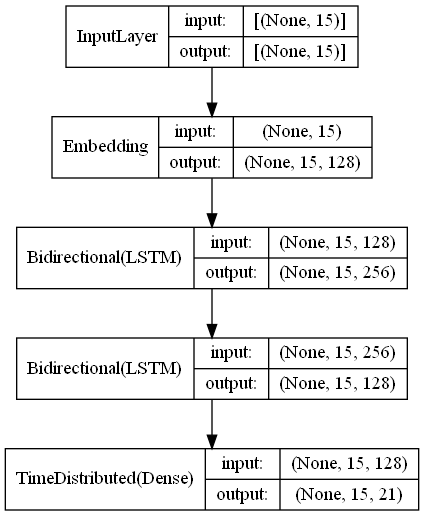

In [129]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
    layers.TimeDistributed(layers.Dense(n_unique_classes, activation="softmax"))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [130]:
# FITTING MODEL

history = model.fit(X_train, y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
177/177 [==============================] - 22s 75ms/step - loss: 0.8212 - accuracy: 0.3227 - val_loss: 0.4525 - val_accuracy: 0.4196
Epoch 2/20
177/177 [==============================] - 13s 72ms/step - loss: 0.2158 - accuracy: 0.5126 - val_loss: 0.0905 - val_accuracy: 0.5436
Epoch 3/20
177/177 [==============================] - 12s 68ms/step - loss: 0.0675 - accuracy: 0.5583 - val_loss: 0.0544 - val_accuracy: 0.5538
Epoch 4/20
177/177 [==============================] - 12s 67ms/step - loss: 0.0421 - accuracy: 0.5645 - val_loss: 0.0443 - val_accuracy: 0.5537
Epoch 5/20
177/177 [==============================] - 12s 67ms/step - loss: 0.0315 - accuracy: 0.5657 - val_loss: 0.0389 - val_accuracy: 0.5554
Epoch 6/20
177/177 [==============================] - 12s 68ms/step - loss: 0.0237 - accuracy: 0.5675 - val_loss: 0.0371 - val_accuracy: 0.5551
Epoch 7/20
177/177 [==============================] - 12s 69ms/step - loss: 0.0189 - accuracy: 0.5684 - val_loss: 0.0361 - val_accuracy:

red is training, blue is validation


<Figure size 432x288 with 0 Axes>

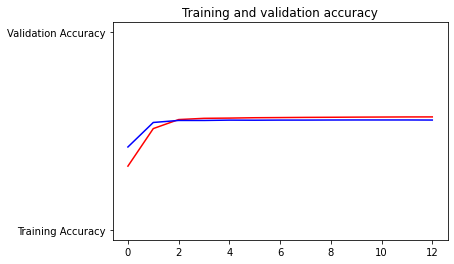

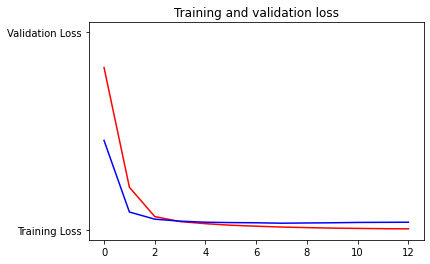

<Figure size 432x288 with 0 Axes>

In [131]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [132]:
# SAVING MODEL
# model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

In [133]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
cm_pred = y_pred.argmax(axis=-1).flatten()
cm_true = y_test.argmax(axis=-1).flatten()

In [167]:
count = 0
for seq in test_data['Polarity'].to_numpy():
    count += len(seq)
count
print("test_data polarities length", count)
print("cm_pred shape", cm_pred.shape)
print("cm_true shape", cm_true.shape)
print("MEANING", cm_pred.shape[0]-count, "polarities are paddings")
print(cm_pred[:50])
print(cm_true[:50])

test_data polarities length 16140
cm_pred shape (34590,)
cm_true shape (34590,)
MEANING 18450 polarities are paddings
[10 11 11  9  9 11 11 10 11 11 11 11 11 11 11 12 11 11 12  4 11 11 11 11
 11 11 11 11 11 11 11 11 11 12  4 11 11 11 11 11 11 11 11 11 11 12 12 11
  9  8]
[10 11 11  9  9 11 11 10  0  0  0  0  0  0  0 12 11 11 12  0  0  0  0  0
  0  0  0  0  0  0 11 11 11 11 11 11 12  0  0  0  0  0  0  0  0 11 11 11
 11  9]


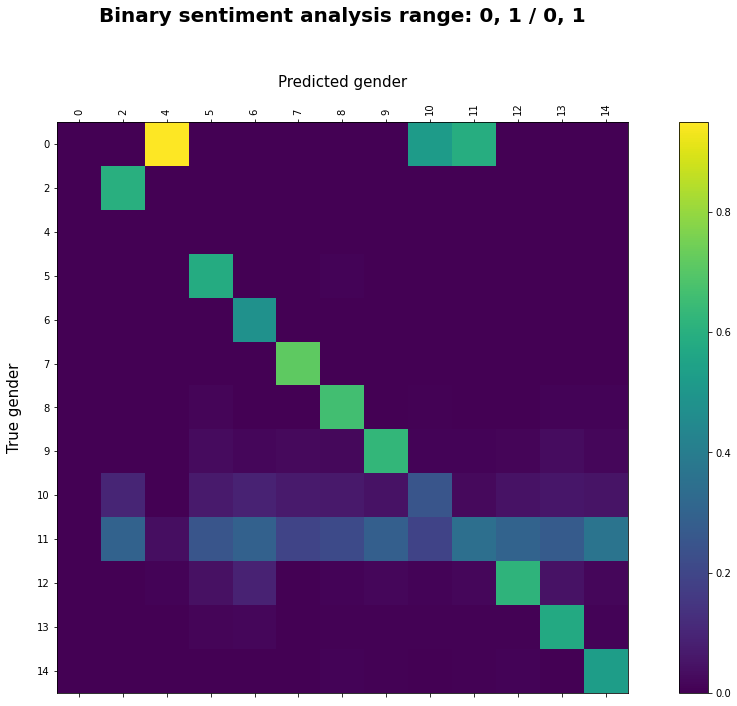

In [134]:
# PLOTTING CONFUSION MATRIX
cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Binary sentiment analysis range: 0, 1 / 0, 1',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []

for x in np.unique(np.array(np.concatenate((cm_true,cm_pred)))):
    cm_axis_vals.append(x)

fig.colorbar(cax)
plt.xticks(range(len(cm_axis_vals)), cm_axis_vals, rotation=90)
plt.yticks(range(len(cm_axis_vals)), cm_axis_vals)
plt.show()

In [142]:
# PRINTING METRICS
from sklearn.metrics import classification_report

report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:len(cm_axis_vals)]
df_perf_2.insert(loc=0, column='Polarity', value=cm_axis_vals)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

,Polarity,precision,recall,f1-score,support
0,0,0.00,0.00,0.00,19013.0
1,2,0.60,0.60,0.60,10.0
2,4,0.00,0.50,0.00,12.0
3,5,0.58,0.61,0.60,69.0
4,6,0.48,0.49,0.49,53.0
5,7,0.72,0.74,0.73,85.0
6,8,0.66,0.70,0.68,291.0
7,9,0.63,0.65,0.64,938.0
8,10,0.25,0.70,0.37,2370.0
9,11,0.35,0.75,0.47,9755.0


In [136]:
# DEFINE XAI FUNCTION
%reload_ext autoreload
%autoreload 2
from classes.data_prepper import DataPrepper

# Borrowed from: https://www.geeksforgeeks.org/python-program-to-find-n-largest-elements-from-a-list/
# Function returns N largest elements
def Nmaxelements(list, N):
    return list[:N]

def find_complete_sentence(sentence_number, sentences):
    index = sentences.index[sentences['Sentence #'] == sentence_number].tolist()[0]
    return sentences['Text'][index]

def XAI(predictions, input_data, N_greatest_polarities):
    p = DataPrepper()
    complete_sentences = pd.read_json('../datasets/7_sentences.json')

    for pred, row in zip(predictions, input_data.iterrows()):
        data = row[1]

        print("\n---------------------------------------------------------------------------------------")
        print("The sentence:", '"'+find_complete_sentence(data['Sentence #'], complete_sentences)+'".\n')
        print("Was predicted to be", 'masculine' if pred == 0 else 'feminine', "("+str(pred)+").\n")

        print("Most", 'masculine' if pred == 0 else 'feminine', "words in sentence are:\n")
        greatest_pols = []

        if (pred == 0):
            greatest_pols = Nmaxelements(sorted(data['Polarity']), N_greatest_polarities)
        else:
            greatest_pols = Nmaxelements(sorted(data['Polarity'], reverse=True), N_greatest_polarities)

        for pol in greatest_pols:
            i = data['Polarity'].index(pol)
            print("'"+data["Word"][i]+"'", "with a polarity of", round(pol,2))
        

In [137]:
# USE XAI ON PREDICTIONS
XAI(y_pred[:100], test_data, 2)

constructor of DataPrepper

---------------------------------------------------------------------------------------
The sentence: "If you're in the Minnesota area, click over to CBS to find out how to score tickets to see the Diana exhibit in person.".



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()